In [985]:
import timeit
import numpy as np
import pandas as pd
from scipy import integrate
from pykalman import KalmanFilter
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns

In [986]:
import plotly.express as px

In [987]:
from plotly.offline import plot, iplot, init_notebook_mode
# Make plotly work with Jupyter notebook
init_notebook_mode(connected=True)

### State Extrapolation Equation
- Using the state extrapolation equation, we can predict the next system state, based on the knowledge of the current state. It extrapolates state vector from the present (time step n ) to the future (time step n+1).


- x^n+1,n=Fx^n,n+Gu^n,n+wn
- Where:
- x^n+1,n	is a predicted system state vector at time step n+1
- x^n,n	is an estimated system state vector at time step n
- u^n,n	is a control variable or input variable - a measurable (deterministic) input to the system
- wn	is a process noise or disturbance - an unmeasurable input that affects the state
- F	is a state transition matrix
- G	is a control matrix or input transition matrix (mapping control to state variables)


In [149]:
def state_extrapolation(cur_state_vec, control_vec, transition_mat, control_mat):
    
    """
    Function extraploates state_vec from time step t to time step t + 1, cur_state_vec(t,t), next_state_vec(t+1, t)
    Variable Dimensions:
    cur_state_vec: n * 1
    transition_mat: n * n 
    control_mat: n * m
    control_vec: m * 1
    noise_vec: n * 1
    """
    
#     print(transition_mat, transition_mat.shape)
#     print(cur_state_vec, cur_state_vec.shape)
#     print(control_mat, control_mat.shape)
#     print(control_vec, control_vec.shape)
#     print(np.dot(transition_mat, cur_state_vec))
#     print(np.dot(control_mat, control_vec))
    next_state_vec = np.dot(transition_mat, cur_state_vec) + np.dot(control_mat, control_vec)
    return next_state_vec

### Solve for F & G (Helper Functions)

#### Given your dynamic input with your state vec and your control vec, determine what F & G are, functionality currently manually
THE STATE SPACE REPRESENTATION
You might be wandering, why the state space representation must be in the following form:

x˙(t)=Ax(t)+Bu(t)
y(t)=Cx(t)+Du(t)

### Covariance Extrapolation Update

Pn+1,n=FPn,nFT+Q
Where:
Pn,n	is an estimate uncertainty (covariance) matrix of the current sate
Pn+1,n	is a predicted estimate uncertainty (covariance) matrix for the next state
F	is a state transition matrix that we've derived in "Modeling linear dynamic systems" section
B	is a input matrix
Q	is a process noise matrix


In [6]:
def cov_extrapolation(cur_cov_mat, transition_mat, process_noise_mat):
    next_cov_mat = np.linalg.multi_dot([transition_mat, cur_cov_mat, transition_mat.transpose()]) + process_noise_mat
    return next_cov_mat

In [17]:
def calc_process_noise_mat(noise_var, control_mat, time_dependence, continuous=False, control_mat_func=None, delta_t=0):
    
    if type(noise_var) != np.ndarray and not time_dependence:
        noise_var = np.full((control_mat.shape[0],1),noise_var)
    elif type(noise_var) != np.ndarray:
        noise_var = np.full((control_mat.shape[0], control_mat.shape[0]), noise_var)
        
    if not time_dependence:
        process_noise_mat = np.diag(noise_var)
    else:
        # discrete
        if not continuous:
            process_noise_mat = np.multiply(np.dot(control_mat, control_mat.transpose()))
        else:
            dim = noise_vec.shape[0]
            process_noise_mat = np.eye(dim)
#             print(dim)
            for x in range(dim):
                for y in range(dim):
                    process_noise_mat[x][y] = noise_integral(delta_t, x, y, control_mat_func, delta_t)
            process_noise_mat = np.multiply(noise_var, process_noise_mat)
            
    return process_noise_mat

def integrand(t, dim_x, dim_y):
    control_mat = np.array([t**2/2,t, t**3/3])
    control_mat_t = np.transpose(np.matrix(control_mat))
    return np.array(np.multiply(control_mat, control_mat_t))[dim_x][dim_y]

def noise_integral(t, dim_x, dim_y, control_mat_func, delta_t):
    return integrate.quad(control_mat_func, 0, delta_t, args=(dim_x, dim_y))[0]

In [8]:
calc_process_noise_mat(
    noise_vec=np.array([0,1,2]),
    control_mat=np.array([[0,1],[1,2]]),
    time_dependence=True,
    continuous=True,
    control_mat_func=integrand,
    delta_t=5)

TypeError: calc_process_noise_mat() got an unexpected keyword argument 'noise_vec'

### Measurement Equation
zn=Hxn+vn
Where:
zn	is a measurement vector
xn	is a true system state (hidden state)
vn	a random noise vector
H	is an observation matrix


In [15]:
def measure_update(cur_state_vec, observation_mat, measure_noise_vec):
    """
    Dimension:
    State Vec n * 1
    Observation Matrix z * n
    Noise Vec z * 1
    """
    measure_vec = np.dot(observation_mat, cur_state_vec) + measure_noise_vec
    return measure_vec

### State Update Equation
x^n,n=x^n,n−1+Kn(zn−Hx^n,n−1)
where:
x^n,n	is a estimated system state vector at time step n
x^n,n−1	is a predicted system state vector at time step n−1
Kn	is a Kalman Gain
zn	is a measurement
H	is an observation matrix



x	state vector	nx×1
z	output vector	nz×1
H	observation matrix	nz×nx
K	Kalman gain	nx×nz

In [557]:
def state_update(prev_next_state_vec, kalman_gain_mat, measure_vec, observation_mat):
    
    """
    Dimension
    Prev next state vec n * 1
    Measure vc z * 1
    Observation Z * X
    Kalman Gain X * Z
    """
#     print(kalman_gain_mat, 'kalman gain', kalman_gain_mat.shape)
#     print(measure - np.dot(observation_mat, prev_next_state_vec), 'observation', np.dot(observation_mat, prev_next_state_vec).shape)
#     print(np.dot(kalman_gain_mat, measure_vec - np.dot(observation_mat, prev_next_state_vec)), 'whatever', np.dot(kalman_gain_mat, measure_vec - np.dot(observation_mat, prev_next_state_vec)).shape)

    
    next_state_vec = prev_next_state_vec + np.dot(kalman_gain_mat, measure_vec - np.dot(observation_mat, prev_next_state_vec))
    return next_state_vec

### Cov Update

Pn,n=(I−KnH)Pn,n−1(I−KnH)T+KnRnKTn
where:
Pn,n	is an estimate uncertainty (covariance) matrix of the current sate
Pn,n−1	is a prior estimate uncertainty (covariance) matrix of the current sate (predicted at the previous state)
Kn	is a Kalman Gain
H	is an observation matrix
Rn	is a Measurement Uncertainty (measurement noise covariance matrix)

In [703]:
def cov_update(prev_next_cov_mat, kalman_gain_mat, observation_mat, measure_noise_mat):
    """
    Kalman Gain X * Z
    Observation Z * X
    Identity X * X
    Previous Cov Mat  X * X
    Measure Noise Z * 1
    
    """
    
#     measure_noise_mat = np.cov(np.dot(np.matrix(measure_noise_vec).transpose(), np.matrix(measure_noise_vec)))
    
    identity_mat = np.eye(kalman_gain_mat.shape[0])
    
    next_cov_mat = prev_next_cov_mat
    
    first_part = np.subtract(identity_mat, np.dot(kalman_gain_mat, observation_mat))    
    next_cov_mat = np.linalg.multi_dot([first_part, prev_next_cov_mat, first_part.transpose()]) + \
                   np.linalg.multi_dot([kalman_gain_mat, measure_noise_mat, kalman_gain_mat.transpose()])
    
    return next_cov_mat



def cov_update_simplified(prev_next_cov_mat, kalman_gain_mat, observation_mat, measure_noise_mat):
    
    identity_mat = np.eye(kalman_gain_mat.shape[0])
    next_cov_mat = np.dot(
                        np.subtract(identity_mat, np.dot(kalman_gain_mat, observation_mat)),
                        prev_next_cov_mat
    )
    return next_cov_mat

### Kalman Gain Equation


Kn=Pn,n−1HT(HPn,n−1HT+Rn)−1
where:
Kn	is the Kalman Gain
Pn,n−1	is a prior estimate uncertainty (covariance) matrix of the current sate (predicted at the previous state)
H	is an observation matrix
Rn	is a Measurement Uncertainty (measurement noise covariance matrix)

In [13]:
def calc_kalman_gain(prev_next_cov_mat, observation_mat, measure_noise_mat):
    """
    observation_mat Z * X
    prev_next_cov_mat  X * X
    measure_noise_mat Z * Z
    
    """
#     print('observation', observation_mat.shape, observation_mat, observation_mat.transpose().shape)
#     print('covariance', prev_next_cov_mat.shape, prev_next_cov_mat)
#     print('measure', measure_noise_mat, measure_noise_mat.shape)
    
    
    kalman_gain_mat = np.linalg.multi_dot([
        prev_next_cov_mat,
        observation_mat.transpose(),
        np.linalg.inv(
            np.linalg.multi_dot([observation_mat, prev_next_cov_mat, observation_mat.transpose()]) + measure_noise_mat
        )]
    )
    
#     print(prev_next_cov_mat)
#     print(np.linalg.multi_dot([observation_mat, prev_next_cov_mat, observation_mat.transpose()]) + measure_noise_mat)
    return kalman_gain_mat

In [ ]:
class KalmanFilter:
    
    
    def __init__(self, init_state_vec, init_state_cov, transition_mat, observation_mat, control_mat):
        pass
    
    
    def predict(self, cur_state_vec, control_vec, noise_vec, transition_mat, control_mat, process_noise_mat):
        
        pred_next_state_vec = state_extrapolation(cur_state_vec, control_vec, process_noise_vec, transition_mat, control_mat)
        pred_next_cov_mat = cov_extrapolation(cur_cov_mat, transition_mat, process_noise_mat)
        
    def update(self, prev_next_cov_mat, prev_next_state_vec, observation_mat, measure_vec, measure_noise_mat):
        
        kalman_gain_mat = calc_kalman_gain(prev_next_cov_mat, observation_mat, measure_noise_mat)
        cur_state_vec = state_update(prev_next_state_vec, kalman_gain_mat, measure_vec, observation_mat)
        cur_state_cov_mat = cov_update(prev_next_cov_mat, kalman_gain_mat, observation_mat, measure_noise_mat)


###  Plan
- Understanding of Multi-Dimensional Kalman Filter, Review KalmanFilter.Net
- Process Noise Matrix Q & Measurement Noise Matrix R Determination (Time-Variant/Independent/Discrete/Continuous)
- Test on One Dimensional Data (Weight of Gold) (Done) Compare with pyKalman
- Test on Multi-Dimensional Data (One Dimension Moving), Compare with pyKalman
- Test on Multi-Dimensional Data (With Velocity & Acceleration Changing), Compare with pyKalman
- Test on Financial Data, Compare with pyKalman
- Test on Cointegrated Pair
- Merge all 5 equations into a Class Object
- Pandas compatibility
- Transition & Control Matrix Auxiliary Helpers (Derivatives Calculation)
- Vectorized Implementation (if possible)

- Assume distribution for the noise (noise is normally distributed)
- Model (Covariance Matrix is unknown, Collect Data (Fitted Covariance Matrix))
- Standard Error of Observation (0.05, that is the standard deviation of the error)

### Initialize Covariance Matrix is ERROR Covariance (High if you think your initial estimate is inaccurate)

In [ ]:
### Noise Vector Variance Independent or given variance, multiply by control matrix (From Experiment)
### Measurement Uncertainty


In [ ]:
"""

All noises are assumed as Gaussian models in KF and EKF. To determine the values for the measurement noise you need to collect a sample data sets from the sensors that you are using. For each data set you can calculate the variance value put it to the corresponding position of the measurement noise covariance matrix.

Usually process noise covariances are experimental values. You can use a trial and error method to find the values which reduce the error.


"""

### Weighting Gold (Comparing results with pyKalman)
- Results are consistent

In [1012]:
measure_var = 100
init_state_vec = np.asarray(0)
init_state_cov = np.matrix(500)
transition_mat = np.matrix(1)
control_mat = np.matrix(0)
control_vec = np.zeros(1)
observation_mat = np.matrix(1)
measure_noise_mat = np.matrix(measure_var)
process_noise_mat = np.matrix(0.00)
true_value = 1000

In [1013]:
kf = KalmanFilter(n_dim_obs=1, 
                  n_dim_state=1, 
                  initial_state_mean=init_state_vec,
                  initial_state_covariance=init_state_cov,
                  transition_matrices=transition_mat,
                  observation_matrices=observation_mat,
                  observation_covariance=measure_noise_mat,
                  transition_covariance=process_noise_mat)

In [1017]:
prev_next_state_vec = state_extrapolation(init_state_vec, control_vec, transition_mat, control_mat)
prev_next_cov_mat = cov_extrapolation(init_state_cov, transition_mat, process_noise_mat)

kalman_gain_list = []
cur_state_vec_list = []
cur_state_cov_list = []
measurements = measure_var * np.random.randn(2000) + true_value
for measure in measurements:
    measure_vec = np.asarray(measure)
    kalman_gain_mat = calc_kalman_gain(prev_next_cov_mat, observation_mat, measure_noise_mat)
    kalman_gain_list.append(kalman_gain_mat.item(0))

    cur_state_vec = state_update(prev_next_state_vec, kalman_gain_mat, measure_vec, observation_mat)
    cur_state_cov_mat = cov_update(prev_next_cov_mat, kalman_gain_mat, observation_mat, measure_noise_mat)
    
    cur_state_vec_list.append(cur_state_vec.item(0))
    cur_state_cov_list.append(cur_state_cov_mat.item(0))
    
    prev_next_state_vec = state_extrapolation(cur_state_vec, control_vec, transition_mat, control_mat)
    prev_next_cov_mat = cov_extrapolation(cur_state_cov_mat, transition_mat, process_noise_mat)

    

prev_next_cov_mat = init_state_cov
prev_next_state_vec = init_state_vec

cur_state_vec_list_2 = []
cur_state_cov_list_2 = []
    
for measure in measurements:
    measure_vec = np.asarray(measure)
    prev_next_state_vec, prev_next_cov_mat = kf.filter_update(prev_next_state_vec, prev_next_cov_mat,
                    observation=measure_vec,
                    observation_matrix=observation_mat)
    
    
#     print(prev_next_state_vec)
#     print(type(prev_next_state_vec.item(0)))
    cur_state_vec_list_2.append(prev_next_state_vec.item(0))
    cur_state_cov_list_2.append(prev_next_cov_mat.item(0))


    
    
res_df = pd.DataFrame({'KALMAN_GAIN': kalman_gain_list, 'CUR_STATE': cur_state_vec_list, 'CUR_STATE_STANDARD': cur_state_vec_list_2, 'CUR_COV_STANDARD': cur_state_cov_list_2, 'CUR_COV': cur_state_cov_list, 'TRUE_VALUE': true_value, 'MEASUREMENT': measurements})

In [1018]:
px.line(pd.melt(
    res_df, value_vars=['CUR_STATE', 'CUR_STATE_STANDARD']), y='value', color='variable',
       title='PREDICTION ITERATION')

In [1019]:
px.line(pd.melt(
    res_df, value_vars=['CUR_COV', 'CUR_COV_STANDARD']), y='value', color='variable',
       title='KALMAN GAIN ITERATION')

### Constant Velocity Aircraft in One Dimension (Comparing results with pyKalman)
- State is Position
- Control is Velocity


- PyKalman merges control and transition into one matrices, so had to maneuver
- Vec, Cov shape in pyKalman is different
- Results are identical
- pyKalman disadvantage (Cannot set error in the control matrix straightforwardly)


- Assumption is good initial estiate(low covariance, close to true value initial estimate)
- Large Measurement Error

In [1020]:
measure_var = 10
init_state_vec = np.array([7,10])#.reshape(-1,1)
init_state_cov = np.matrix([[250,0],[0,0]]) #Assume I am highly confident of velocity, but not position
transition_mat = np.matrix([[1,1],[0,1]])
control_mat = np.matrix([1,0]).reshape(-1,1)
control_vec = np.array([10]).reshape(-1,1) # Velocity is constant at 10
observation_mat = np.matrix([1,0])#.reshape(-1,1) # Can only observe position
measure_noise_mat = np.matrix(measure_var)
process_noise_mat = np.matrix([[1,0],[0,0]])

In [1021]:
kf = KalmanFilter(n_dim_obs=1, 
                  n_dim_state=2, 
                  initial_state_mean=init_state_vec,
                  initial_state_covariance=init_state_cov,
                  transition_matrices=transition_mat,
                  observation_matrices=observation_mat,
                  observation_covariance=measure_noise_mat,
                  transition_covariance=process_noise_mat)

In [1022]:
 # Can only observe position
init_state_vec = init_state_vec.reshape(-1,1)
transition_mat = np.matrix(np.eye(2))

In [1023]:
num_moves = 100

In [1024]:
start = timeit.default_timer()
prev_next_state_vec = state_extrapolation(init_state_vec, control_vec, transition_mat, control_mat)
prev_next_cov_mat = cov_extrapolation(init_state_cov, transition_mat, process_noise_mat)

kalman_gain_list = []
cur_state_vec_list = []
cur_state_cov_list = []
measurements = np.arange(0, num_moves, 1) * 10 + 50 + measure_var * np.random.randn(num_moves)
true_value = np.arange(0, num_moves, 1) * 10 + 50

for measure in measurements:
    measure_vec = np.asarray(measure)
    kalman_gain_mat = calc_kalman_gain(prev_next_cov_mat, observation_mat, measure_noise_mat)
    kalman_gain_list.append(kalman_gain_mat.item(0))

    cur_state_vec = state_update(prev_next_state_vec, kalman_gain_mat, measure_vec, observation_mat)
    cur_state_cov_mat = cov_update(prev_next_cov_mat, kalman_gain_mat, observation_mat, measure_noise_mat)
    
    cur_state_vec_list.append(cur_state_vec.item(0))
    cur_state_cov_list.append(cur_state_cov_mat.item(0))
    
    prev_next_state_vec = state_extrapolation(cur_state_vec, control_vec, transition_mat, control_mat)
    prev_next_cov_mat = cov_extrapolation(cur_state_cov_mat, transition_mat, process_noise_mat)

    
end = timeit.default_timer()
print(end - start)
start = timeit.default_timer()

prev_next_cov_mat = init_state_cov
prev_next_state_vec = init_state_vec

cur_state_vec_list_2 = []
cur_state_cov_list_2 = []
    
for measure in measurements:
    measure_vec = np.asarray(measure)
    prev_next_state_vec, prev_next_cov_mat = kf.filter_update(prev_next_state_vec, prev_next_cov_mat,
                    observation=measure_vec,
                    observation_matrix=observation_mat)
    cur_state_vec_list_2.append(prev_next_state_vec.item(0))
    cur_state_cov_list_2.append(prev_next_cov_mat.item(0))
    
end = timeit.default_timer()   
print(end - start)

    
res_df = pd.DataFrame({'KALMAN_GAIN': kalman_gain_list, 
                       'CUR_STATE': cur_state_vec_list, 
                       'CUR_STATE_STANDARD': cur_state_vec_list_2, 
                       'CUR_COV_STANDARD': cur_state_cov_list_2, 
                       'CUR_COV': cur_state_cov_list, 
                       'TRUE_VALUE': true_value, 
                       'MEASUREMENT': measurements})

0.011254900000494672
0.06475646699982462


In [1025]:
res_df['MEASUREMENT_ERROR'] = res_df['MEASUREMENT'] - res_df['TRUE_VALUE']
res_df['KALMAN_ERROR'] = res_df['CUR_STATE'] - res_df['TRUE_VALUE']

In [1026]:
px.line(pd.melt(
    res_df, value_vars=['CUR_STATE', 'CUR_STATE_STANDARD', 'TRUE_VALUE', 'MEASUREMENT']), y='value', color='variable',
       title='PREDICTION ITERATION')

In [1027]:
px.line(pd.melt(
    res_df, value_vars=['CUR_COV', 'CUR_COV_STANDARD']), y='value', color='variable',
       title='COV ITERATION')

In [1028]:
px.line(pd.melt(
    res_df, value_vars=['KALMAN_GAIN']), y='value', color='variable',
       title='KALMAN GAIN ITERATION')

In [1029]:
px.line(pd.melt(
    res_df, value_vars=['MEASUREMENT_ERROR', 'KALMAN_ERROR']), y='value', color='variable',
       title='PREDICTION ITERATION')

In [1030]:
res_df['MEASUREMENT_ERROR'].mean(), res_df['MEASUREMENT_ERROR'].std()

(-0.6176110350157885, 10.046597902640409)

In [1031]:
res_df['KALMAN_ERROR'].mean(), res_df['KALMAN_ERROR'].std()

(-0.5164636144743514, 3.9810789600041607)

### Constant Acceleration Aircraft in One Dimension (Comparing results with pyKalman)
- If higher acceleration (best strategy is to use keep 3rd derivative as control vec (which should never change))
- Or updating your control vec (not recommended)

In [1043]:
measure_var = 500
init_state_vec = np.array([0,10,2])#.reshape(-1,1)
init_state_cov = np.matrix([[250,0,0],[0,0,0], [0,0,0]]) #Assume I am highly confident of velocity and acceleration
transition_mat = np.matrix([[1,1,0.5],[0,1,1], [0,0,1]])
control_mat = np.array([0.5,1,0.05]).reshape(-1,1)
control_vec = np.array([2]).reshape(-1,1) # Acceleration is constant at 2
observation_mat = np.matrix([1,0,0])#.reshape(-1,1) # Can only observe position
measure_noise_mat = np.matrix(measure_var)
process_noise_mat = np.matrix([[1,0,0],[0,0,0],[0,0,0]])

In [1044]:
kf = KalmanFilter(n_dim_obs=1, 
                  n_dim_state=3, 
                  initial_state_mean=init_state_vec,
                  initial_state_covariance=init_state_cov,
                  transition_matrices=transition_mat,
                  observation_matrices=observation_mat,
                  observation_covariance=measure_noise_mat,
                  transition_covariance=process_noise_mat)

In [1045]:
 # Can only observe position
init_state_vec = init_state_vec.reshape(-1,1)
transition_mat = np.matrix([[1,1,0],[0,1,0], [0,0,1]])

In [1046]:
num_moves = 60

In [1047]:
true_value = np.zeros(num_moves)
true_velocity = np.arange(0, num_moves, 1) * 2 + 10
true_value[0] = 150
for i, val in enumerate(true_value):
    if i > 0:
        true_value[i] = true_value[i - 1] + true_velocity[i - 1] + 1
    

In [1048]:
start = timeit.default_timer()
prev_next_state_vec = state_extrapolation(init_state_vec, control_vec, transition_mat, control_mat)
prev_next_cov_mat = cov_extrapolation(init_state_cov, transition_mat, process_noise_mat)

# print(prev_next_state_vec)
kalman_gain_list = []
cur_state_vec_list = []
cur_state_cov_list = []
measurements = true_value + measure_var * np.random.randn(num_moves)

count = 0
for measure in measurements:
    measure_vec = np.asarray(measure)
    kalman_gain_mat = calc_kalman_gain(prev_next_cov_mat, observation_mat, measure_noise_mat)
    kalman_gain_list.append(kalman_gain_mat.item(0))
    
    cur_state_vec = state_update(prev_next_state_vec, kalman_gain_mat, measure_vec, observation_mat)
    cur_state_cov_mat = cov_update(prev_next_cov_mat, kalman_gain_mat, observation_mat, measure_noise_mat)
    cur_state_vec_list.append(cur_state_vec.item(0))
    cur_state_cov_list.append(cur_state_cov_mat.item(0))
    
    prev_next_state_vec = state_extrapolation(cur_state_vec,  control_vec, transition_mat, control_mat)
    prev_next_cov_mat = cov_extrapolation(cur_state_cov_mat, transition_mat, process_noise_mat)
#     print(prev_next_state_vec)

    

    
end = timeit.default_timer()
print(end - start)
start = timeit.default_timer()

prev_next_cov_mat = init_state_cov
prev_next_state_vec = init_state_vec

cur_state_vec_list_2 = []
cur_state_cov_list_2 = []
    
for measure in measurements:
    measure_vec = np.asarray(measure)
    prev_next_state_vec, prev_next_cov_mat = kf.filter_update(prev_next_state_vec, prev_next_cov_mat,
                    observation=measure_vec,
                    observation_matrix=observation_mat)
    cur_state_vec_list_2.append(prev_next_state_vec.item(0))
    cur_state_cov_list_2.append(prev_next_cov_mat.item(0))
    
end = timeit.default_timer()   
print(end - start)

    
res_df = pd.DataFrame({'KALMAN_GAIN': kalman_gain_list, 
                       'CUR_STATE': cur_state_vec_list, 
                       'CUR_STATE_STANDARD': cur_state_vec_list_2, 
                       'CUR_COV_STANDARD': cur_state_cov_list_2, 
                       'CUR_COV': cur_state_cov_list, 
                       'TRUE_VALUE': true_value, 
                       'MEASUREMENT': measurements})

0.007443744001648156
0.03851847299665678


In [1049]:
res_df['MEASUREMENT_ERROR'] = res_df['MEASUREMENT'] - res_df['TRUE_VALUE']
res_df['KALMAN_ERROR'] = res_df['CUR_STATE'] - res_df['TRUE_VALUE']

In [1050]:
px.line(pd.melt(
    res_df, value_vars=['CUR_STATE', 'CUR_STATE_STANDARD', 'TRUE_VALUE', 'MEASUREMENT']), y='value', color='variable',
       title='PREDICTION ITERATION')

In [1051]:
px.line(pd.melt(
    res_df, value_vars=['CUR_COV', 'CUR_COV_STANDARD']), y='value', color='variable',
       title='COV ITERATION')

In [1052]:
px.line(pd.melt(
    res_df, value_vars=['KALMAN_GAIN']), y='value', color='variable',
       title='KALMAN GAIN ITERATION')

In [1053]:
px.line(pd.melt(
    res_df, value_vars=['MEASUREMENT_ERROR', 'KALMAN_ERROR']), y='value', color='variable',
       title='PREDICTION ITERATION')

### Multi-Dimensional Constant Acceleration (Comparing results with pyKalman)
- Consistent result
- Large Error


In [1073]:
init_state_vec = np.array([0,0,0,3,2,1, 0, 0.1, 0.22])#.reshape(-1,1)
observation_mat = np.concatenate(
    (np.eye(3),
    np.zeros(shape=(3,6))),
    axis=1)
init_state_cov = np.eye(9) * 5
init_state_cov[6][6] = 0
init_state_cov[7][7] = 0
init_state_cov[8][8] = 0
# Can only observe position
measure_var = 20
measure_noise_mat = np.eye(3) * measure_var
process_noise_mat = np.zeros(shape=(9,9))
process_noise_mat[0][0] = 0.1
process_noise_mat[1][1] = 0.1
process_noise_mat[2][2] = 0.1

In [1074]:
transition_mat = np.eye(9)
transition_mat[0][3] = 1
transition_mat[1][4] = 1
transition_mat[2][5] = 1
transition_mat[3][6] = 1
transition_mat[4][7] = 1
transition_mat[5][8] = 1
transition_mat[0][6] = 0.5
transition_mat[1][7] = 0.5
transition_mat[2][8] = 0.5

In [1075]:
# for i in [init_state_vec, transition_mat, observation_mat, process_noise_mat, init_state_cov]:
#     print(i)

In [1076]:
kf = KalmanFilter(n_dim_obs=3, 
                  n_dim_state=9, 
                  initial_state_mean=init_state_vec,
                  initial_state_covariance=init_state_cov,
                  transition_matrices=transition_mat,
                  observation_matrices=observation_mat,
                  observation_covariance=measure_noise_mat,
                  transition_covariance=process_noise_mat)

In [1077]:
### Alternative Version

In [1078]:
control_mat = np.zeros(shape=(6,3))
control_mat[0][0] = 0.5
control_mat[1][1] = 0.5
control_mat[2][2] = 0.5
control_mat[3][0] = 1
control_mat[4][1] = 1
control_mat[5][2] = 1
control_vec = np.array([0,0.1,0.22]).reshape(-1,1)

In [1079]:
 # Can only observe position
init_state_vec = init_state_vec[0:6].reshape(-1,1)
transition_mat = np.eye(6)
transition_mat[0][3] = 1
transition_mat[1][4] = 1
transition_mat[2][5] = 1

observation_mat = np.concatenate(
    (np.eye(3),
    np.zeros(shape=(3,3))),
    axis=1)

process_noise_mat = np.zeros(shape=(6,6))
process_noise_mat[0][0] = 0.1
process_noise_mat[1][1] = 0.1
process_noise_mat[2][2] = 0.1

init_state_cov = np.eye(6) * 5

In [1080]:
num_moves = 100

In [1081]:
#np.array([0,0,0,3,2,1, 0, 0.1, 0.22])
true_velocity = \
    np.transpose(
        np.arange(0, num_moves, 1) * np.array([0,0.1,0.22]).reshape(-1,1) + \
    np.concatenate((
        np.full(fill_value=3,shape=(1, num_moves)),
        np.full(fill_value=2,shape=(1, num_moves)),
        np.full(fill_value=1,shape=(1, num_moves))
    ),axis=0)
    )

In [1082]:
true_position =  np.zeros(shape=(num_moves,3))
for i in range(1,len(true_position)):
    true_position[i] = true_position[i-1] + true_velocity[i] + 0.5 * np.array([0,0.1,0.22])

In [1083]:
measurements = true_position + measure_var * np.random.randn(num_moves * 3).reshape(num_moves,3)

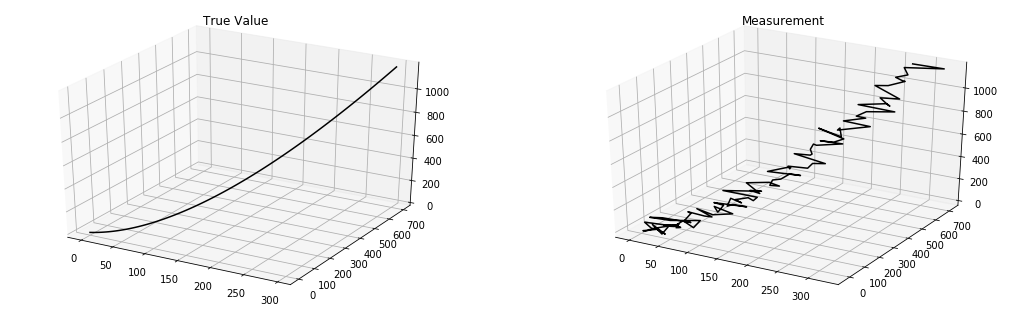

In [1084]:
%matplotlib inline
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(221, projection='3d')
xline = np.take(true_position, indices=[0], axis=1).reshape(-1);
yline = np.take(true_position, indices=[1], axis=1).reshape(-1);
zline = np.take(true_position, indices=[2], axis=1).reshape(-1);
ax.plot3D(xline, yline, zline, 'black')
ax.set_title("True Value");

ax = fig.add_subplot(222, projection='3d')
xline = np.take(measurements, indices=[0], axis=1).reshape(-1);
yline = np.take(measurements, indices=[1], axis=1).reshape(-1);
zline = np.take(measurements, indices=[2], axis=1).reshape(-1);

ax.plot3D(xline, yline, zline, 'black');
ax.set_title("Measurement");


plt.show()

In [1085]:
start = timeit.default_timer()
cur_state_vec = init_state_vec
cur_state_cov_mat = init_state_cov

kalman_gain_mean = []
cur_state_x = []
cur_state_y = []
cur_state_z = []
# cur_state_cov_mean = []

for measure in measurements:
    measure_vec = np.asarray(measure).reshape(-1,1)

    prev_next_state_vec = state_extrapolation(cur_state_vec,  control_vec, transition_mat, control_mat)
    prev_next_cov_mat = cov_extrapolation(cur_state_cov_mat, transition_mat, process_noise_mat)
    kalman_gain_mat = calc_kalman_gain(prev_next_cov_mat, observation_mat, measure_noise_mat)
    kalman_gain_mean += [np.mean(kalman_gain_mat)]

    cur_state_vec = state_update(prev_next_state_vec, kalman_gain_mat, measure_vec, observation_mat)
    cur_state_cov_mat = cov_update(prev_next_cov_mat, kalman_gain_mat, observation_mat, measure_noise_mat)
    
    cur_state_x += [cur_state_vec[0][0]]
    cur_state_y += [cur_state_vec[1][0]]
    cur_state_z += [cur_state_vec[2][0]]
#     cur_state_cov_mean += [np.mean(cur_state_cov_mat)]

    
    
end = timeit.default_timer()
print(end - start)


start = timeit.default_timer()

init_state_vec = np.array([0,0,0,3,2,1, 0, 0.1, 0.22])#.reshape(-1,1)
observation_mat = np.concatenate(
    (np.eye(3),
    np.zeros(shape=(3,6))),
    axis=1)
init_state_cov = np.eye(9) * 5
init_state_cov[6][6] = 0
init_state_cov[7][7] = 0
init_state_cov[8][8] = 0

cur_state_x_2 = []
cur_state_y_2 = []
cur_state_z_2 = []
cur_state_cov_mean_2 = []
prev_next_state_vec = init_state_vec
prev_next_cov_mat = init_state_cov

# cur_state_vec = init_state_vec
# cur_state_cov_mat = init_state_cov

for measure in measurements:
    measure_vec = np.asarray(measure)
    prev_next_state_vec, prev_next_cov_mat = kf.filter_update(prev_next_state_vec, prev_next_cov_mat,
                    observation=measure_vec,
                    observation_matrix=observation_mat)

    cur_state_x_2 += [prev_next_state_vec[0]]
    cur_state_y_2 += [prev_next_state_vec[1]]
    cur_state_z_2 += [prev_next_state_vec[2]]
#     cur_state_cov_mean += [np.mean(prev_next_cov_mat)]
    
end = timeit.default_timer()   
print(end - start)

0.02032076600153232
0.06310866499916301


In [1086]:
res_array = np.array([np.array(x) for x in [kalman_gain_mean,
    cur_state_x,
    cur_state_y,  
    cur_state_z,
    cur_state_x_2,
    cur_state_y_2,
    cur_state_z_2,
    np.take(true_position, indices=[0], axis=1).reshape(-1),
    np.take(true_position, indices=[1], axis=1).reshape(-1),
    np.take(true_position, indices=[2], axis=1).reshape(-1),
    np.take(measurements, indices=[0], axis=1).reshape(-1),
    np.take(measurements, indices=[1], axis=1).reshape(-1),
    np.take(measurements, indices=[2], axis=1).reshape(-1)]]).transpose()


res_df = pd.DataFrame(
    res_array, columns=['KALMAN_GAIN', 'X', 'Y', 'Z', 'X_2', 'Y_2', 'Z_2', 'TRUE_X', 'TRUE_Y', 'TRUE_Z', 'MEASURE_X', 'MEASURE_Y', 'MEASURE_Z'])
res_df = res_df.reset_index().rename({'index': 'ITERATION'}, axis=1)

In [1087]:
res_df['ERROR'] = np.sqrt((res_df['X'] - res_df['TRUE_X'])**2 + (res_df['Y'] - res_df['TRUE_Y'])**2 + (res_df['Z'] - res_df['TRUE_Z'])**2)
res_df['ERROR_STANDARD'] = np.sqrt((res_df['X_2'] - res_df['TRUE_X'])**2 + (res_df['Y_2'] - res_df['TRUE_Y'])**2 + (res_df['Z_2'] - res_df['TRUE_Z'])**2)
res_df['ERROR_MEASUREMENT'] = np.sqrt((res_df['MEASURE_X'] - res_df['TRUE_X'])**2 + (res_df['MEASURE_Y'] - res_df['TRUE_Y'])**2 + (res_df['MEASURE_Z'] - res_df['TRUE_Z'])**2)

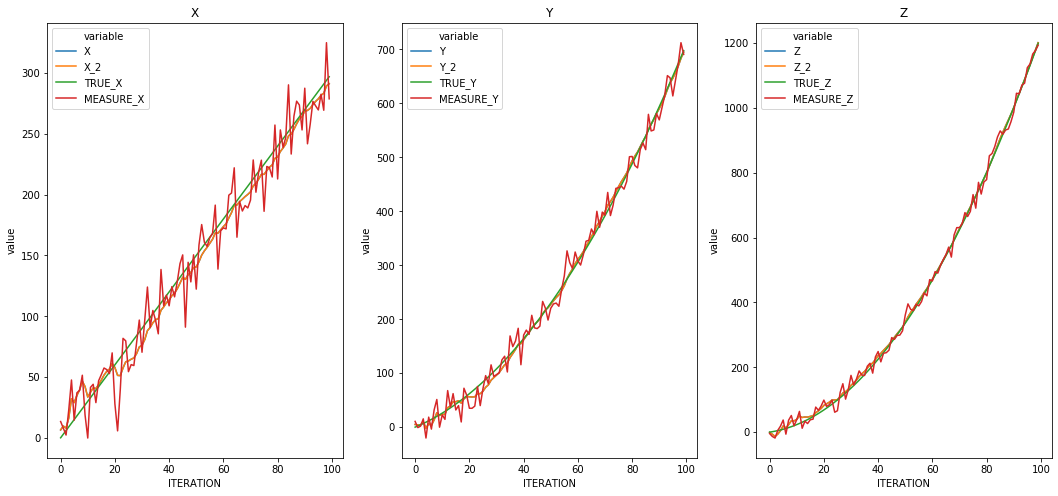

In [1088]:
fig, ax= plt.subplots(1, 3, figsize=(18, 8));
for i, coordinate in enumerate(['X', 'Y', 'Z']):
    s = sns.lineplot(data=pd.melt(
        res_df, id_vars=['ITERATION'], value_vars=[coordinate, f'{coordinate}_2', f'TRUE_{coordinate}', f'MEASURE_{coordinate}']), x='ITERATION', y='value', hue='variable', ax=ax[i]);
    s.set_title(coordinate);
plt.show()


In [1089]:
px.line(pd.melt(
        res_df, id_vars=['ITERATION'], value_vars=['ERROR', 'ERROR_STANDARD', 'ERROR_MEASUREMENT']), x='ITERATION', y='value', color='variable', title='ERROR')


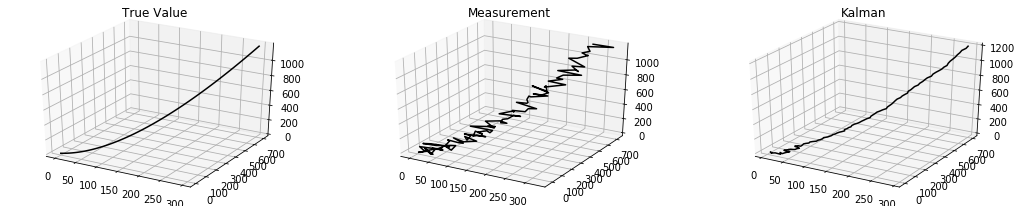

In [1090]:
%matplotlib inline
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(331, projection='3d')
xline = np.take(true_position, indices=[0], axis=1).reshape(-1);
yline = np.take(true_position, indices=[1], axis=1).reshape(-1);
zline = np.take(true_position, indices=[2], axis=1).reshape(-1);
ax.plot3D(xline, yline, zline, 'black')
ax.set_title("True Value");

ax = fig.add_subplot(332, projection='3d')
xline = np.take(measurements, indices=[0], axis=1).reshape(-1);
yline = np.take(measurements, indices=[1], axis=1).reshape(-1);
zline = np.take(measurements, indices=[2], axis=1).reshape(-1);

ax.plot3D(xline, yline, zline, 'black');
ax.set_title("Measurement");

ax = fig.add_subplot(333, projection='3d')
xline = res_df['X'];
yline = res_df['Y'];
zline = res_df['Z'];

ax.plot3D(xline, yline, zline, 'black');
ax.set_title("Kalman");
plt.show()